# COVID-19 - Clinical Data to assess diagnosis

<br>
<br>

👩‍💻 _Gabriela Oliveira da Trindade_

# >> Introduction
---

## <span style="color:blue"> Problem </span> 🎯

This is the Final Project of Alura Bootcamp - Applied Data Science. The goal here is to solve the problem 'COVID-19 - Clinical Data to assess diagnosis' presented on the Kaggle platform.

Sírio Libanes is a large Hospital in the State of São Paulo and in Brasilia that is working on the battle against COVID-19. The data and the problem were described by their Data Intelligence Team.

Here, all the problem description - Context, Call to action, Task, and Dataset -  was gotten from [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

<br>
<br>

❗ Important:
- All the data is anonymous to protect each patient's information.
- The decision on how it's organized and grouped was taken by the Sírio Libanes Team - specialists. So the data is almost prepared.
- I'm not an epidemiologist, virologist or even work on health area. I'm just exploring data, learning and practing Machine Learning and Python. So I'll not draw conclusions on that level.

### Context

COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources. \
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

### Call to action

There is urgency in obtaining accurate that to better predict and prepare healthcare systems and avoid collapse, defined by above capacity need of ICU beds (assuming human resources, PPE and professionals are available), using individual clinical data - in lieu of epidemiological and populational data.

### Task

**Predict admission to the ICU of confirmed COVID-19 cases.** \
Based on the data available, is it feasible to predict which patients will need intensive care unit support? \
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.

**Predict NOT admission to the ICU of confirmed COVID-19 cases.** \
Based on the subsample of widely available data, is it feasible to predict which patients will need intensive care unit support? \
The aim is to provide local and temporary hospitals a good enough answer, so frontline physicians can safely discharge and remotely follow up with these patients.

### Dataset

This dataset contains anonymized data from Hospital Sírio-Libanês, São Paulo and Brasilia. All data were anonymized following the best international practices and recommendations. \
Data has been cleaned and scaled by column according to Min Max Scaler to fit between -1 and 1.

## <span style="color:blue"> The notebook </span>📝

This is a Jupyter Notebook. Here you'll find Python code snippets as well as texts that allows the reader understading some conclusions, decisions and insights.

Some texts will comes with a '**>>**' signal in a different color, to highlight their purposes.

- **<span style="color: red">>></span>** This illustrate a decision taken.
- **<span style="color: yellow">>></span>** This illustrate an insight.
- **<span style="color: green">>></span>** This illustrate a conclusion.

# >> Summary
---

# 1. Libraries

In [1]:
from zipfile import ZipFile
from io import BytesIO
import requests

import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

In [2]:
# config
# pd.set_option('display.max_rows', None)

sns.set_theme(rc={'figure.figsize':(11.7,6.27)})

plt.style.use({'axes.labelsize': 16,
               'axes.titlesize': 19,
               'xtick.labelsize': 12,
               'ytick.labelsize': 12
              })

# 2. Getting the data

In [3]:
data_url_zip = requests.get('https://github.com/gabrielatrindade/alura-bootcamp/blob/master/module5/patient.zip?raw=true')

zipfile = ZipFile(BytesIO(data_url_zip.content))
file_name= zipfile.namelist()[0]

patients = pd.read_excel(zipfile.open(file_name).read())

# 3. Functions used

In [42]:
def create_freq_table(df: pd.DataFrame, variable: str) -> pd.DataFrame:
    
    value_count_variable = df[variable].value_counts()
    
    value_count_variable_normalized = \
        df[variable].value_counts(normalize=True)
    
    return pd.DataFrame({'count': value_count_variable,
                         'percentage': round(value_count_variable_normalized * 100, 2)})


# Cleaning

def ICU_clean(rows):
    
    # check if that patient went to UCI, if yes
    if(np.any(rows['ICU'])):
        # attribute 1 for ICU_x in all the rows
        rows['ICU_x'] = 1
    else:
        rows['ICU_x'] = 0
        
    return rows


def fill_continuous_vars(df: pd.DataFrame, method: str):
    
    continuous_features_cols = df.iloc[:, 13:-2].columns

    filled_continuous_features = (df.groupby('PATIENT_VISIT_IDENTIFIER')
                                    [continuous_features_cols]
                                    .fillna(method=method)
                                    .reset_index())

    categorical_features = df.iloc[:, :13].reset_index(drop=True)

    output = df.iloc[:, -2:].reset_index(drop=True)

    return pd.concat([categorical_features, 
                      filled_continuous_features, 
                      output], 
                     axis=1)


# Visualization

def add_labels_to_bars(ax, series: pd.Series, distance_bar: float):
    '''get a plot and a Series that represent the labels
    and then add the labels to bar tops
    distance_bar = label distance from bar top'''
    
    i=0
    for p in ax.patches:
        
        try:
            value = series.iloc[i]
            height = p.get_height() + distance_bar
        except IndexError:
            value = 0
            height = 0 + distance_bar
            
        ax.text(p.get_x()+p.get_width()/2., height,
                value, fontsize=12,
                ha="center")
        
        i += 1
        

# Feature Engineering

def add_new_features(df: pd.DataFrame):

    df["BLOODPRESSURE_ARTERIAL_MEAN"] = (df['BLOODPRESSURE_SISTOLIC_MEAN'] + 
                                         2*df['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
 
    df["NEUTROPHILES/LINFOCITOS"] = df['NEUTROPHILES_MEAN']/df['LINFOCITOS_MEAN']

    df["GASO"] = df.groupby("PATIENT_VISIT_IDENTIFIER") \
                   .P02_ARTERIAL_MEAN \
                   .apply(lambda x: x.fillna(method='ffill'))
    
    df["GASO"] = (~df["GASO"].isna()).astype(int)

    return df


# Feature Selection

def sirio_libanes_feature_selection(df: pd.DataFrame):
    
    return df[["ICU","WINDOW",
               "PATIENT_VISIT_IDENTIFIER",
               "AGE_ABOVE65", 
               "GENDER", 
               "BLOODPRESSURE_ARTERIAL_MEAN", 
               "NEUTROPHILES/LINFOCITOS",
               "RESPIRATORY_RATE_MAX", 
               "HTN", 
               'DISEASE GROUPING 1',
               'DISEASE GROUPING 2',
               'DISEASE GROUPING 3',
               'DISEASE GROUPING 4',
               'DISEASE GROUPING 5',
               'DISEASE GROUPING 6',
               "GASO",
               "OXYGEN_SATURATION_MIN",
               "HEART_RATE_MAX",
               "PCR_MEAN",
               "CREATININ_MEAN"]]

# 4. Exploratory Analysis and Preprocessing data

These two steps will performed together. I'll clear the data at the same time that I'll explore it.

## Understading the data

In [5]:
patients.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [6]:
patients.columns.values

array(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL',
       'GENDER', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5',
       'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER',
       'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN',
       'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN',
       'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF',
       'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN',
       'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN',
       'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
   

### Available data [[1]](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)

1. Patient demographic information (03)
2. Patient previous grouped diseases (09)
3. Blood results (36)
4. Vital signs (06)

In total there are 54 features, expanded when pertinent to the mean, median, max, min, diff and relative diff.

1. diff = max - min
2. relative diff = diff/median


### <span style="color: green">>></span> The `ICU` variable is our target.

In [7]:
patients['ICU'].unique()

array([0, 1])

In [8]:
patients.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
patients.shape

(1925, 231)

### <span style="color: yellow">>></span> The dataset have 1925 rows and 231 columns.

In [10]:
patients['PATIENT_VISIT_IDENTIFIER'].nunique()

385

### <span style="color: yellow">>></span> Despite the dataset has  1925 rows, it has only 385 unique patients, which means that each row does not represent a patient.

### Through the problem description we can understand what represent each row. See bellow.

In [11]:
len(patients.groupby(['PATIENT_VISIT_IDENTIFIER', 'WINDOW']).count())

1925

### <span style="color: green">>></span> The `PATIENT_VISIT_IDENTIFIER` and `WINDOW` variables together are unique. They can represent each row.

But what does `WINDOW` variable mean? \
It represents a period of time that the exams of each patient were taken. \
The window has an interval of 2 hours, therefore, all the exam values of each line were collected in the respective window.

<br>
<br>

To understand better, from Kaggle description we have:

> We were carefull to include real life cenarios of with window of events and available data.

<table>
    <thead>
        <tr>
            <th>Window</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>0-2</td>
            <td>From 0 to 2 hours of the admission</td>
        </tr>
        <tr>
            <td>2-4</td>
            <td>From 2 to 4 hours of the admission</td>
        </tr>
        <tr>
            <td>4-6</td>
            <td>From 4 to 6 hours of the admission</td>
        </tr>
        <tr>
            <td>6-12</td>
            <td>From 6 to 12 hours of the admission</td>
        </tr>
        <tr>
            <td>Above-12</td>
            <td>Above 12 hours from admission</td>
        </tr>
    </tbody>
</table>


However, we are not sure about the exact time the exams were taken. So, for that rows which has 1 in the `ICU` variable we don't know if the exams were done before or after the patient went there.

### <span style="color: red">>></span> Then for those lines with `ICU equals 1` we cannot considerate the information. We need remove them. And assign the signal if the patient went or not to the `ICU` in the lines before. 

After that, we need decided which window we will consider to train our model.

<br>
<br>

To keep in mind:

> Beware NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.
>
> Example:

![](https://github.com/gabrielatrindade/alura-bootcamp/blob/master/module6/project/figures/figure1.png?raw=true)


## Deleting data that we cannot use to train the model

### Let's clean those information/rows that we cannot use. 

<span style="color: red">>></span>  Action:
- 1st: Remove those pacients who `ICU equals 1` in the `0-2 WINDOW`. 
- 2nd: Keep the `ICU` value of the last window in the previous windows - for it create a new variable to keep this value.
- 3rd: Remove the windows which the `ICU is equals to 1` for each patient. Again: I cannot use this line information even in the backfill step, because I don't know if the exams were taken before or after the goes to the ICU.

In [12]:
UCI_1_window_2_4_patients_identifier = \
    patients[(patients.ICU == 1) &
             (patients.WINDOW == '0-2')] \
            ['PATIENT_VISIT_IDENTIFIER'] \
            .values


patients_cleaned = \
    patients.query('PATIENT_VISIT_IDENTIFIER not in @UCI_1_window_2_4_patients_identifier')

# patients_cleaned

In [13]:
# Create a new ICU variable cleaned

patients_cleaned = patients_cleaned \
                    .groupby('PATIENT_VISIT_IDENTIFIER') \
                    .apply(ICU_clean)

# patients_cleaned

In [14]:
# remove all the lines with ICU == 1, drop ICU column
# and switch ICU_x as ICU target

patients_cleaned = patients_cleaned[patients_cleaned.ICU != 1].copy()

patients_cleaned.drop('ICU', axis=1, inplace=True)

patients_cleaned.rename(columns={'ICU_x': 'ICU'}, inplace=True)

## Target distribution

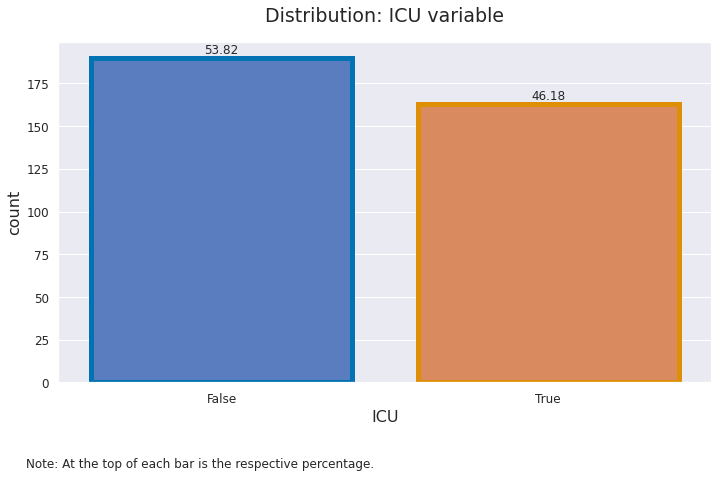

In [15]:
#plt.figure(figsize=(9,6))

ax = sns.countplot(x=patients_cleaned.query('WINDOW == "0-2"')['ICU'],
                   palette="muted",
                   linewidth=5,
                   edgecolor=sns.color_palette("colorblind"))

window_0_2_ICU = patients_cleaned.query('WINDOW == "0-2"')[['ICU']]
window_0_2_ICU_freq_table = create_freq_table(window_0_2_ICU, 'ICU')

add_labels_to_bars(ax, window_0_2_ICU_freq_table['percentage'], 2.6)

plt.title('Distribution: ICU variable', pad=20)
plt.xticks([0, 1],['False', 'True'])

ax.text(-0.6, -50, 'Note: At the top of each bar is the respective percentage.');

### <span style="color: yellow">>></span> Although we don't have a fifty-fifty distribution of the target, it has a good balance.

### Continuing the analysis... What about missing values?

## Understanding the missing values

In [16]:
patients_cleaned.isna().sum().values

array([  0,   0,   0,   0,   5,   5,   5,   5,   5,   5,   5,   5,   5,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877,
       877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 877, 87

In [17]:
columns_with_more_than_800_missing_values = \
    patients_cleaned.columns[ patients_cleaned.isna().sum() > 800 ].values

columns_with_more_than_800_missing_values

array(['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN',
       'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN',
       'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF',
       'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN',
       'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN',
       'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF',
       'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATININ_MIN',
       'CREATININ_MAX', 'CREATININ_DIFF', 'FFA_MEDIAN', 'FFA_MEAN',
       'FFA_MIN', 'FFA_MAX', 'FFA_DIFF', 'GGT_MEDIAN', 'GGT_MEAN',
    

### <span style="color: yellow">>></span> We can see that the columns with missing values are those ones referring to exams... with MAX, MEAN, MIN, MEDIAN, DIFF values.

In [18]:
columns_with_more_than_800_missing_values_plus_id = \
    np.insert(columns_with_more_than_800_missing_values, 
              0, ['PATIENT_VISIT_IDENTIFIER'])

patients_cleaned[columns_with_more_than_800_missing_values_plus_id].head(17)

,PATIENT_VISIT_IDENTIFIER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,...,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.994912,-0.994912,-0.994912,-0.994912,-1.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,...,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Measurements obtained from tests such as blood, blood pressure and temperature, in addition to those we have in the dataset, do not usually increase rapidly over time, but gradually. It potentially presents vital signs and blood labs similar to neighboring windows [[1]](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

### <span style="color: red">>></span> Thinking about it, I decided to use the measurements obtained in the posterior or anterior windows of each patient to fill in the missing values.

## Dealing with missing data

Missing Data


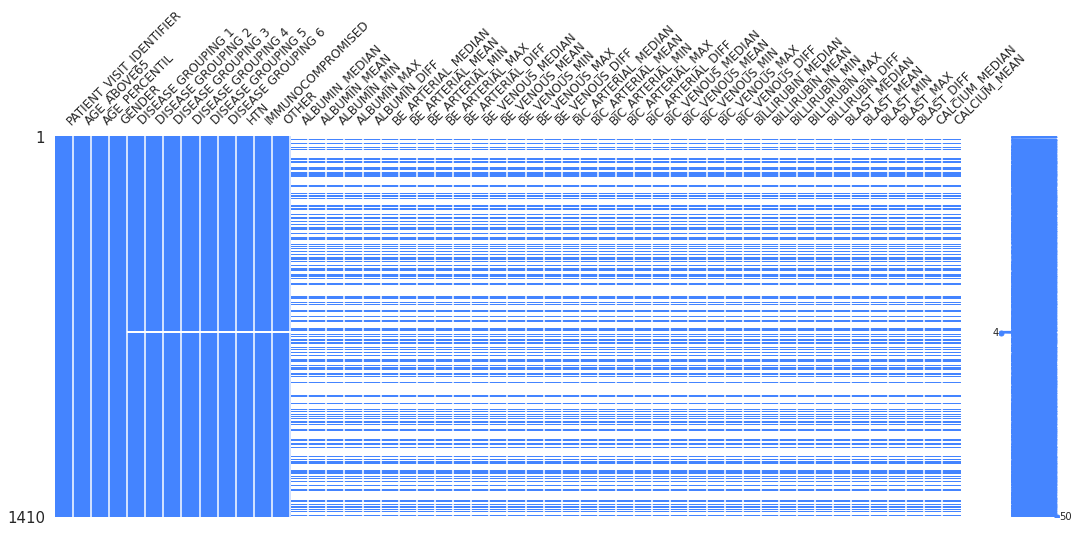

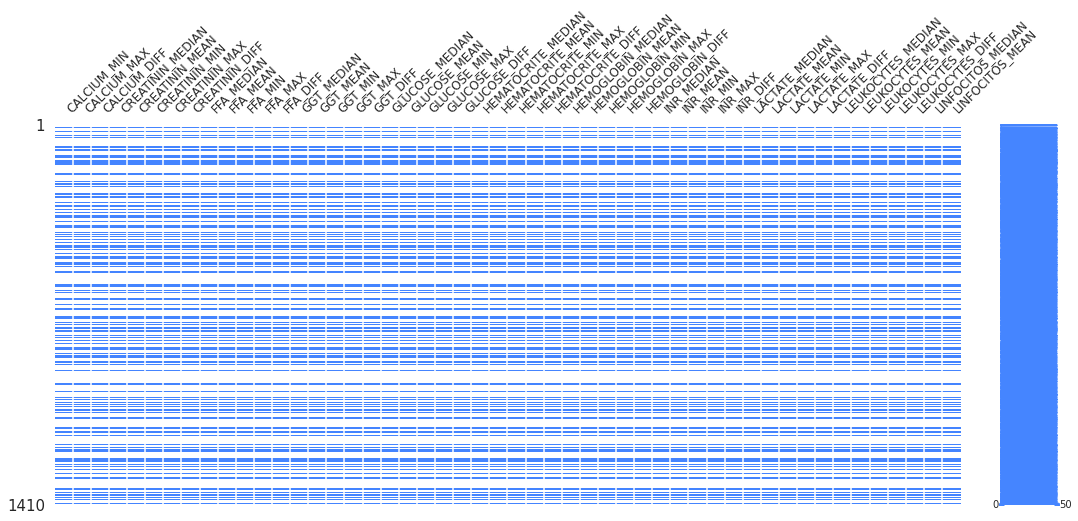

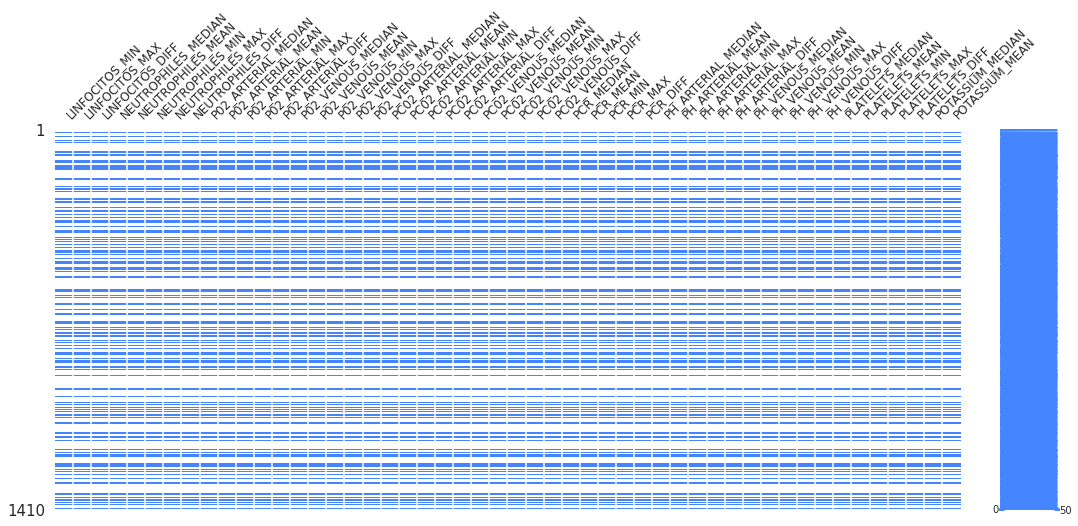

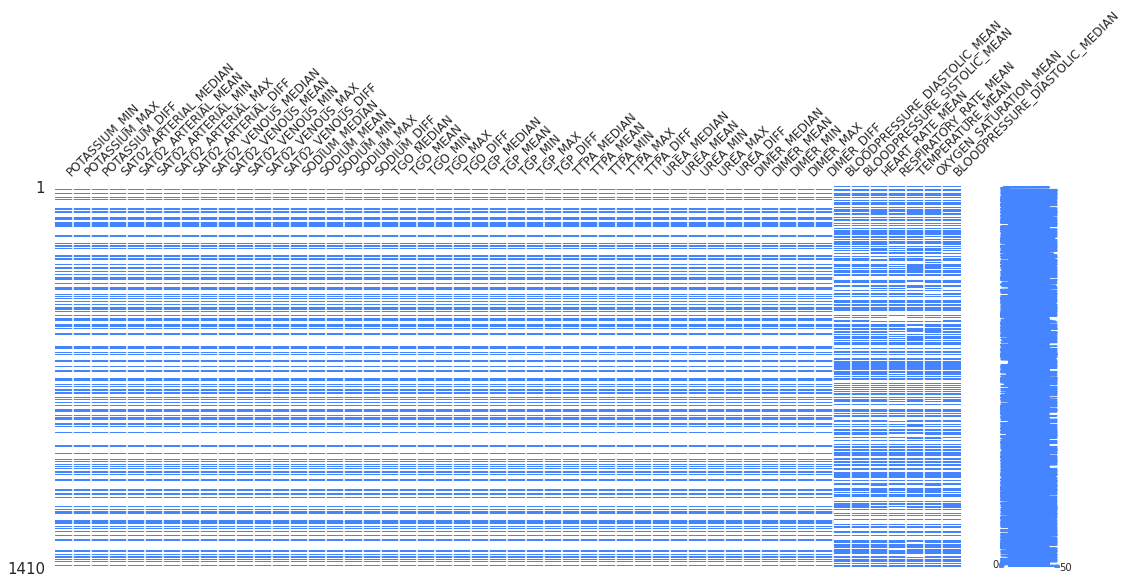

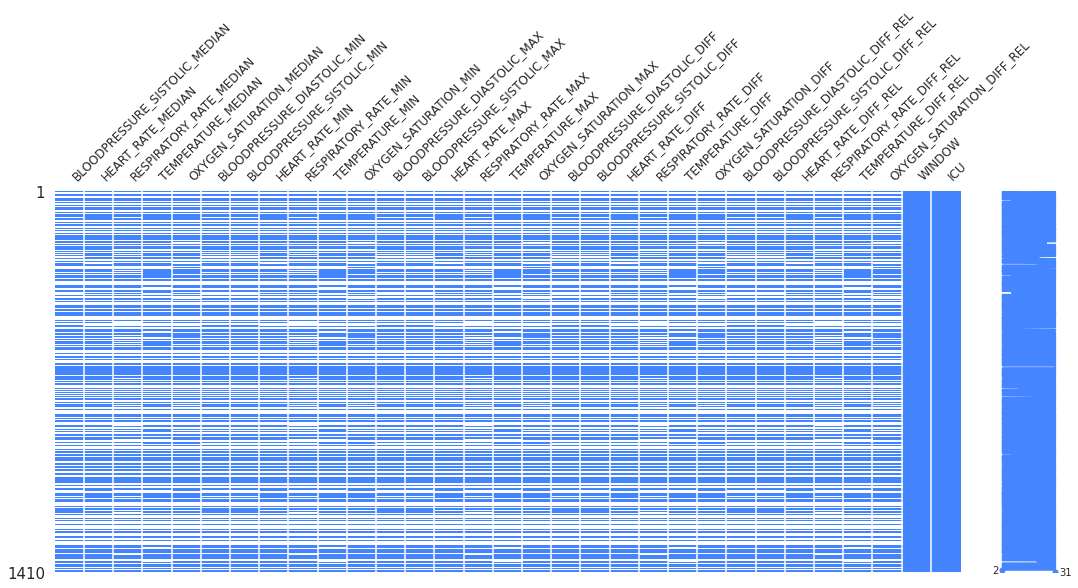

In [19]:
print('Missing Data')

for i in range(0, 231, 50):
    msno.matrix(patients_cleaned.iloc[:,i:i+50], 
                figsize=(18, 7), fontsize=12,
                color=(0.27, 0.52, 1.))

In [20]:
patients_cleaned_filled = fill_continuous_vars(patients_cleaned, 'bfill')
patients_cleaned_filled = fill_continuous_vars(patients_cleaned_filled, 'ffill')

In [21]:
patients_cleaned_filled.isna().sum().values

array([ 0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  0, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 72, 72, 68, 87, 70, 67, 72, 72, 68,
       87, 70, 67, 72, 72, 68, 87, 70, 67, 72, 72, 68, 87, 70, 67, 72, 72,
       68, 87, 70, 67, 72

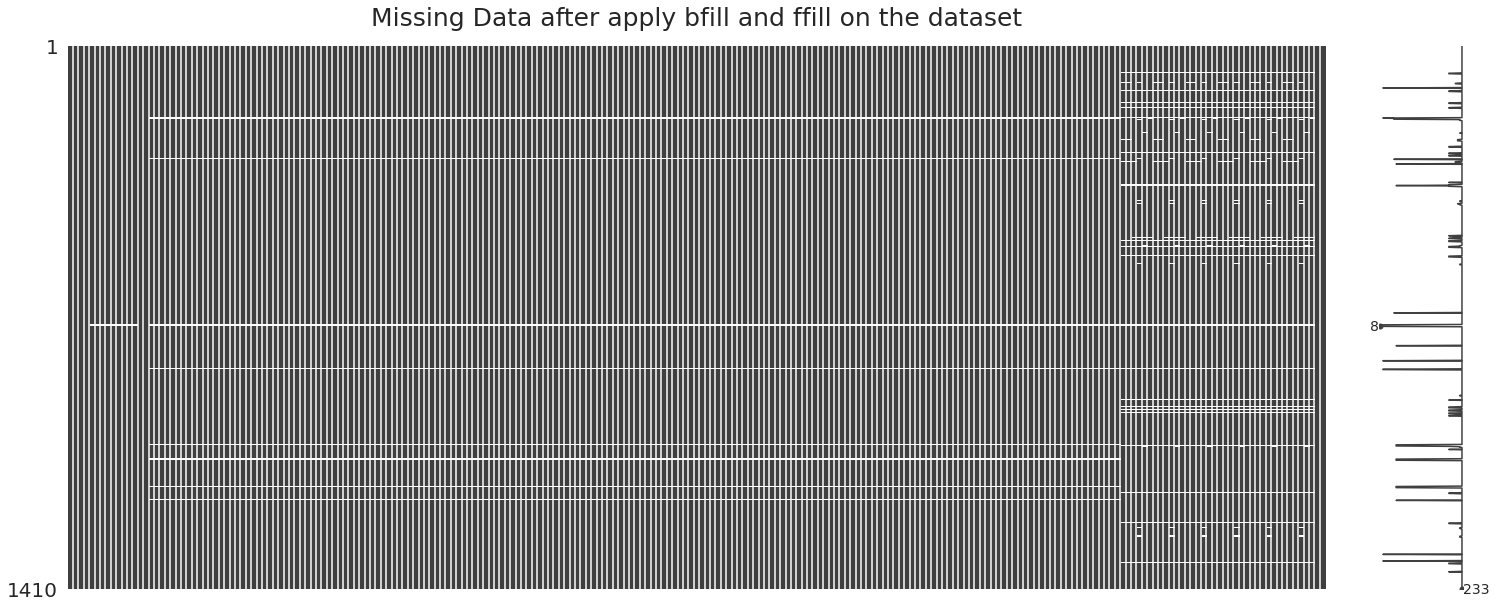

In [22]:
msno.matrix(patients_cleaned_filled)

plt.title('Missing Data after apply bfill and ffill on the dataset',
          fontsize=25, pad=20);

### <span style="color: yellow'">>></span> Even after the fill methods applied on the dataset, we still have NaN values. 

### Let's drop them.

In [23]:
patients_no_missing_values = patients_cleaned_filled.dropna()

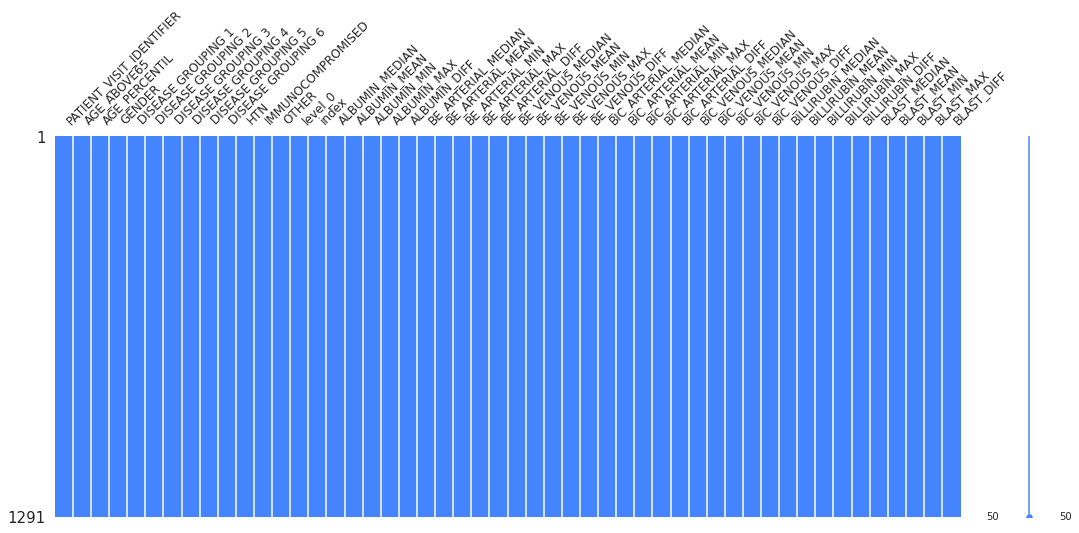

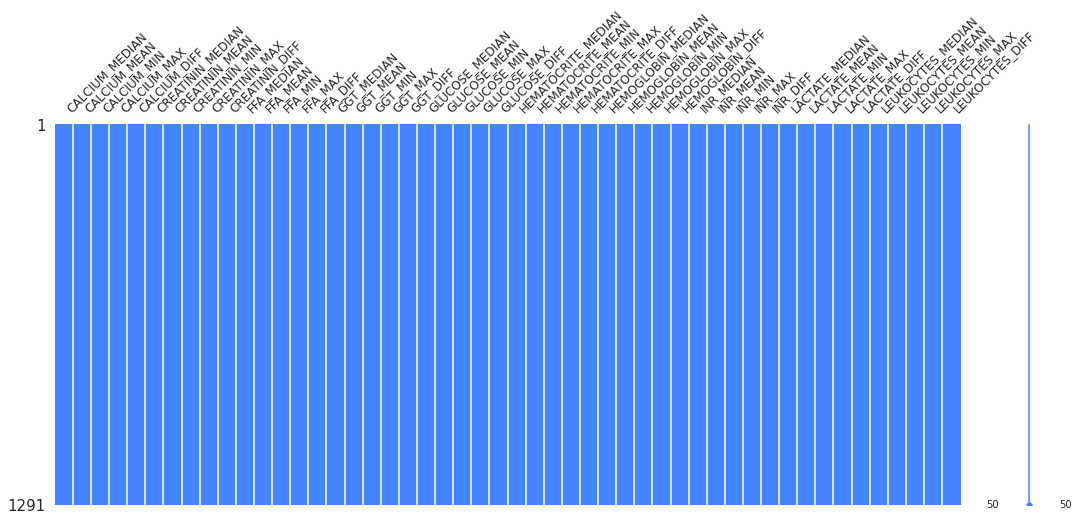

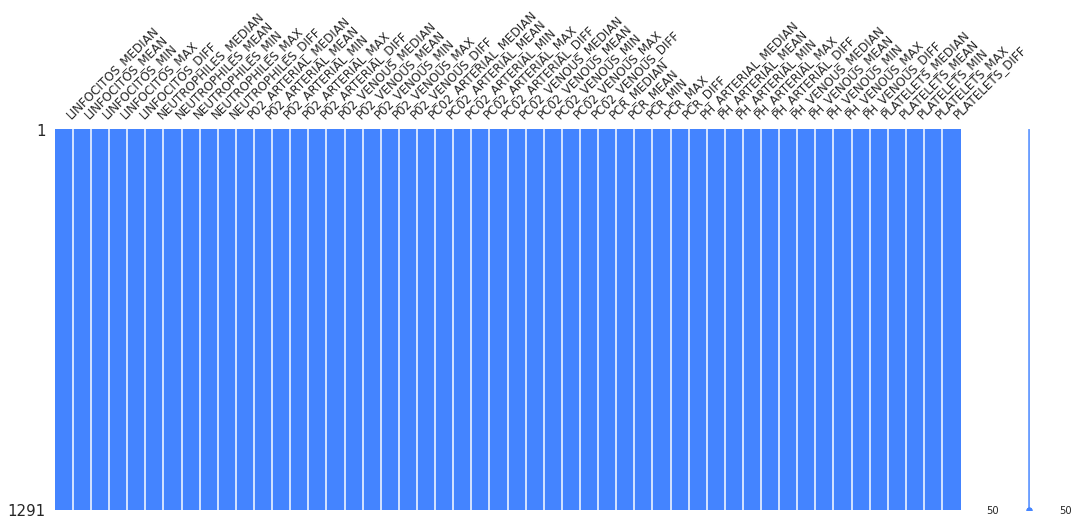

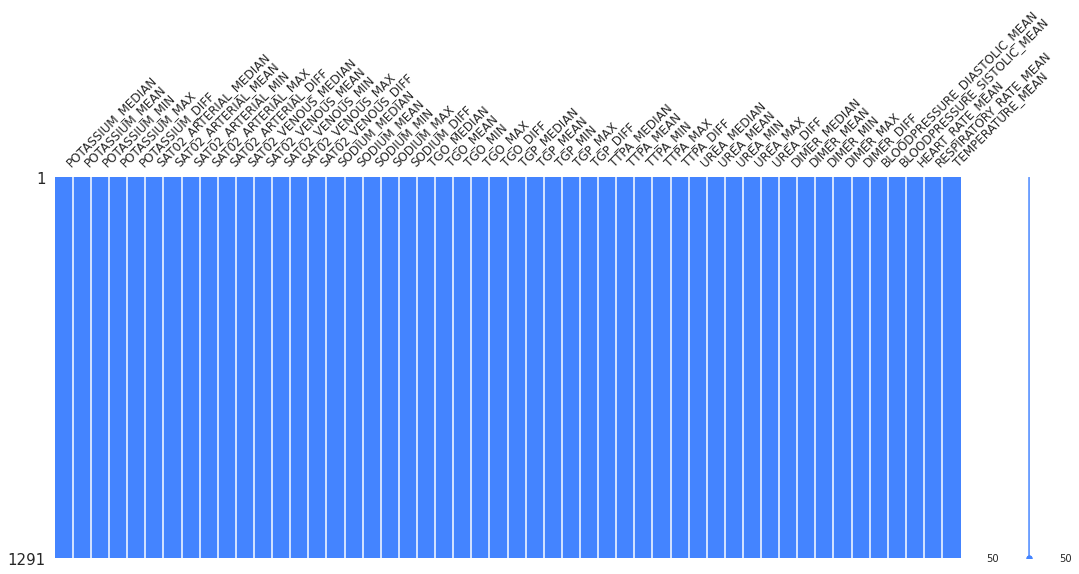

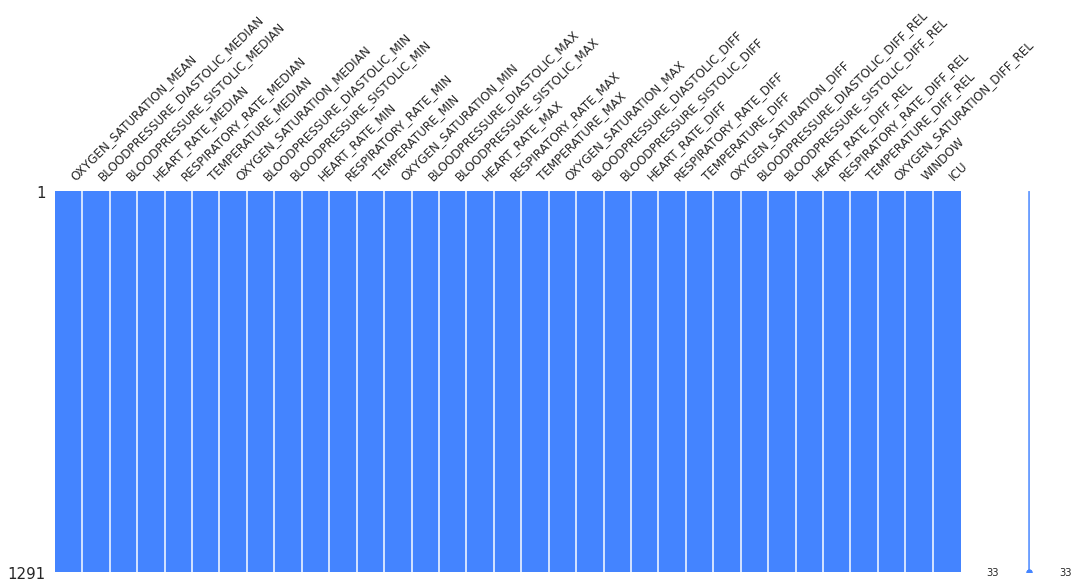

In [24]:
for i in range(0, 231, 50):
    msno.matrix(patients_no_missing_values.iloc[:,i:i+50], 
                figsize=(18, 7), fontsize=12,
                color=(0.27, 0.52, 1.));

In [25]:
patients_no_missing_values['PATIENT_VISIT_IDENTIFIER'].nunique()

294

### <span style="color: yellow">>></span> The columns now have no missing data!

### <span style="color: yellow">>></span> The dataset has 294 patients.

---

### Next step: decide which window will be used to train the machine learning model.

We need to decide on which window to train the model. As we signal whether a patient went to UCI or not, in all windows, we now need to choose which window to use.

The sooner we know whether a patient will go to the UCI or not, it will be better for the Hospital to prepare resources and start earlier an intensive care, if necessary.

### <span style="color: red">>></span> Then, thinking on it, I chose `WINDOW equals 0-2` to train the model because, in this way, we have in the first window the first exams values, and we will be able to do a prediction on future of a patient's situation.

## Selecting data to train the model

In [26]:
patients_cleaned_window_0_2 = patients_no_missing_values \
                                [patients_no_missing_values.WINDOW == '0-2'] \
                                .copy() \
                                .reset_index(drop=True)

patients_cleaned_window_0_2.drop('WINDOW', axis=1, inplace=True)

patients_cleaned_window_0_2

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,380,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
290,381,1,Above 90th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0
291,382,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
292,383,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0


### Now we have all the data cleaned. Then, let's do a brief exploratory analysis to see some distributions.

We can do that using `Pandas Profiling` library.


## Exploratory data analysis on the cleaned data

In [27]:
# profile = ProfileReport(patients_cleaned_window_0_2, minimal=True,
#                         title='Exploratory Data Analysis on Covid-19 Patients')

# profile.to_file('sirio_libanes_report.html')

### <span style="color: yellow'">>></span> Throught the report we can see that:

- Warnings:
    - 35 variables are constant - all of them represent the DIFF values.
    - Others 3 are unique: `PATIENT_VISIT_IDENTIFIER`, `level_0`, and `df_index`.
    - And we also have 10 variables with 0 in 1% to 9.5% of the dataset - depending on the variable. 
    
    
- Overview: 
    - **155 variables are numeric and 77 are categorical**.
    - The dataset has a total of **232 variables and 294 observations**, as we checked before.
    
### I noticed that `AGE_PERCENTIL` variable is an object.

### <span style="color: red">>></span> I'll convert it into an integer.

In [28]:
patients_cleaned_window_0_2[['AGE_PERCENTIL']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   AGE_PERCENTIL  294 non-null    object
dtypes: object(1)
memory usage: 2.4+ KB


In [29]:
patients_cleaned_window_0_2['AGE_PERCENTIL'].unique()

array(['60th', '10th', '40th', '70th', '20th', '50th', '80th', '30th',
       '90th', 'Above 90th'], dtype=object)

In [30]:
patients_cleaned_window_0_2['AGE_PERCENTIL'] = \
    patients_cleaned_window_0_2['AGE_PERCENTIL'] \
        .apply(lambda s: int(s[0]) if s[0].isdigit() else 99)

In [31]:
patients_cleaned_window_0_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Columns: 232 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(7)
memory usage: 533.0 KB


### Now we have all the data with floats and integers.

---

## Feature Engineering

Sirio Libanes' team suggested adding three new features they consider be relevant from the biological point of view, they are `BLOODPRESSURE_ARTERIAL_MEAN`, `NEUTROPHILES/LINFOCITOS`, and `GASO`.

The function for creating these features can be found in the [Functions](#3.-Functions-used) section.

In [43]:
patients_cleaned_window_0_2_added_features = \
    add_new_features(patients_cleaned_window_0_2)

patients_cleaned_window_0_2_added_features.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,GASO
0,0,1,6,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,-0.019310,0.949515,1
1,2,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,-0.554965,0.454450,1
2,3,0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,-0.114846,0.938541,1
3,4,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,0.170940,1.267746,1
4,5,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0,-0.204179,2.487410,1


### After cleaning the rows and creating new colums, we will now work on feature selection.


## Feature Selection

At begining, in the [Avalaible Data](#Available-data-[1]) information, we saw that **some features expanded to the mean, median, max, min, diff and relative diff**.

**Should we work with all them or not?**

I'll create some scenarios to test what will be the best set.

### Scenario 1: All features are included.
Training models with all features. Don't interfere in deciding which one to use or not to use in training.

### Scenario 2: On `Blood Exams` and `Vital Signs` expanded features select one for each group with the best correlation with the target.
In addition to demographic information and previous grouped diseases, select only one of the features expanded (mean, median, max, min, diff and relative diff) for each blood exams and vital signs - choose that one with the highest correlation between it and the target.

### Scenario 3: Remove features with a high correlation between them.

### Scenario 4: On `Blood Exams` and `Vital Signs` expanded features select the `max` ones.

### Scenario 5: Use the features selected by Sírio Libanes team.

### Scenario 6: Use Recursive Feature Elimination (RFE).

In [32]:
patients_cleaned_window_0_2.corr()['ICU']

PATIENT_VISIT_IDENTIFIER     -0.022117
AGE_ABOVE65                   0.242128
AGE_PERCENTIL                 0.133485
GENDER                       -0.136548
DISEASE GROUPING 1            0.048365
                                ...   
HEART_RATE_DIFF_REL          -0.069849
RESPIRATORY_RATE_DIFF_REL    -0.004100
TEMPERATURE_DIFF_REL         -0.068402
OXYGEN_SATURATION_DIFF_REL    0.038372
ICU                           1.000000
Name: ICU, Length: 232, dtype: float64

In [39]:
# plt.figure(figsize=(10, 25))

# sns.heatmap(patients_cleaned_window_0_2.corr()[['ICU']],
#             annot = True,
#             fmt = '.2f',
#             cmap='Blues',
#             vmax=1,
#             vmin=-1)

The first step is to know more about the correlation between our features X and the target y.